In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import pandas as pd
import numpy as np
import matplotlib
from IPython.display import *

import AssembleData

# Anime Trends Based on MyAnimeList

**Authors**: Stephen Chen, Sean Reidy, Roger Liu

**GitHub Repo**: https://github.com/FourSwordKirby/MALDataScience

## Introduction
**Anime**, or Japanese Animation, commonly refers to animated television shows which originate from Japan. The medium contains shows spanning a vast number of genres, with shows geared towards children, such as *Pokemon*, to content aimed at young adults, such as *Full Metal Alchemist*.

![](images/anime.jpg)

[**MyAnimeList**](https://myanimelist.net/) (abbreviated MAL) is an information database website about anime, much like how *IMDb* is a database for movies. It provides metadata about anime titles, such as synopses, the involved production companies, and genres (e.g. “Action” or “Comedy”). Registred users of MAL can rate and review the animes they’ve watched, which MAL then aggregates into a public score from 1 to 10. As such, MAL serves as a useful indicator of which shows are “good” in the community’s eyes, as well as which shows are “famous.”

![](images/mal_example.jpg)

In the past years, with the rise of the Internet, the worldwide community of anime watchers grew larger and more defined, while the anime industry became increasingly aware of its audience. Tropes, or patterns in storytelling and character archetypes, developed to fit fan expectations. But as these tropes were reused over many titles, viewers became increasingly wary of “cookie-cutter” shows, many of which ended up forgotten in the mass of “average” shows. In this context, certain animation studios made their claim to fame by either breaking traditions or producing similar shows but of better technical quality. Long time watchers of anime eventually developed a natural intuition for which shows would be “average” or “good” just from the shows’ descriptions and production studios. These notions motivated the idea that there are some underlying trends in the anime medium.


Our project focused on discovering the underlying patterns of anime and of the anime community by performing data analysis on MAL. We first developed a web scraper which retrieved most of the metadata available on an anime title’s webpage. We then performed data exploration with the purpose of identifying trends within the metadata and exploring relationships between metadata and user scores. We explored trends within each genre, identified patterns within synopsis text, and analyzed the impact of the production studio and source material on popularity. Finally, we addressed the question: “Can we predict the MAL score for an anime title given its metadata?” Our investigation showed that prediction of score is impossible. Instead, we discovered that we can classify which titles are “above average” just from a title’s production studio, genres, source material and length.

In [2]:
'''
We occasionally have personal interpretations of trends in the
context of the anime industry and community. Since they are unimportant
in the analysis, we have seperated them as "trivia" boxes like such.
''';

## Data Collection

![](images/data_examples.jpg)

The scraper we wrote pulled information from MAL about all shows that were airing between 1998 to 2015. Each title was saved as separate JSON files, labeled by their unique MAL id.

User contributions to MAL work as follows. Registered users each have an *AnimeList*, which is an individual profile that allows them to keep track of animes they have "Completed" or "Plan to Watch". Users can score an anime on an integer scale of 1 to 10 if they have completd the series. A page on MAL for an anime title consists of two user aggregates: **score** and **members**. Score is the average of scores that users have given the title. Members is the total number of users who have added the anime to their AnimeList, regardless if appears under the user's "Completed" or "Plan to Watch" list.

Intuitively, score represents how “good” an anime is, and members is an approximation for how “famous” a show is. 

Following is all data fields that appear in the JSON:

![“Fields”](images/fields.png)

### Additional Fields
We computed some additional fields during our data exploration:

![“More Fields”](images/more_fields.png)

## Loading and Cleaning the Data

In [3]:
# Build Dataframe from the data/ folder
# MAL_df, all_genre  = AssembleData.read_files_all(write_csv=True, verbose=True)
# MAL_df = MAL_df.drop_duplicates('id')

In [4]:
# Alternatively save and load to a pickle file for faster loading.
import pickle

# MAL_df = MAL_df.drop_duplicates('id')
# with open('augmented_1998_2015_data.pkl', 'w') as f:
#     pickle.dump(MAL_df, f)
#     pickle.dump(all_genre, f)

with open('augmented_1998_2015_data.pkl', 'r') as f:
    MAL_df = pickle.load(f)
    all_genre = pickle.load(f)

In [5]:
# Sanity Check
MAL_df.drop_duplicates('id', inplace=True)

# Convert studio list to usable form
def fix_studios(l):
    """
        Fixes some the studio names in list l
    """
    # Collapse AIC companies under AIC
    # Collapse Xebec Zwei into Xebec
    for i in xrange(len(l)):
        if l[i].startswith('AIC'):
            l[i] = u'AIC'
        elif l[i].startswith('Xebec'):
            l[i] = u'Xebec'
    return l

MAL_df['studios'] = MAL_df['studios'].apply(lambda s: eval(s))
MAL_df['studios'] = MAL_df['studios'].apply(fix_studios)

# Length computation
MAL_df['length'] = MAL_df['duration'] * MAL_df['episodes']
# Normalize Length to mean 0, std 1 
MAL_df['norm_length'] = (MAL_df['length'] - np.mean(MAL_df['length'])) / np.std(MAL_df['length'])

# Convert start date to usable form
MAL_df['aired_start'] = pd.to_datetime(MAL_df['aired_start'])

# Compute bayes_scores
MAL_df['norm_score'] = (MAL_df['score'] - 1.0) / 9.0
MAL_df['bayes_score'] = (MAL_df['norm_score']*MAL_df['score_users'] + 1.0) / (MAL_df['score_users'] + 2.0)

# Finally index it properly.
MAL_df.reset_index(drop=True, inplace=True)

In [6]:
# The following code block builds a set of all the studios.
# split_field is also needed for later code blocks.

def split_field(df, field, new_field_name=None):
    new_rows = []
    for index, row in df.iterrows():
        for item in row[field]:
            new_rows.append((row['id'], item))
            
    needs_replace = False
    if new_field_name is None or len(new_field_name) == 0:
        new_field_name = "__temp_" + field
        needs_replace = True
        
    right_df = pd.DataFrame(new_rows, columns=['id', new_field_name])
    new_df = pd.merge(df, right_df, how='left', left_on='id', right_on='id')
    if needs_replace:
        del new_df[field]
        new_df[field] = new_df[new_field_name]
        del new_df[new_field_name]
        
    return new_df

def build_studios_set(df):
    split = split_field(df[['id', 'studios']], 'studios')
    split.dropna(axis=0, subset=['studios'], inplace=True)
    return split['studios'].unique()

all_studios = build_studios_set(MAL_df)
print "Number of studios:", all_studios.shape[0]
all_studios[:5]

Number of studios: 302


array([u'Sunrise', u'Madhouse', u'J.C.Staff', u'Tatsunoko Production',
       u'Gonzo'], dtype=object)

In [7]:
# The following code block builds the set of all sources

def build_source_set(df):
    data = df['source'].copy()
    data.dropna(axis=0, inplace=True)
    return data.unique()

all_sources = build_source_set(MAL_df)
print "Number of sources:", all_sources.shape[0]
all_sources

Number of sources: 16


array([u'Original', u'Manga', u'Light novel', u'Unknown', u'Game',
       u'4-koma manga', u'Novel', u'Visual novel', u'Picture book',
       u'Radio', u'Book', u'Other', u'Web manga', u'Card game', u'Music',
       u'Digital manga'], dtype=object)

In [8]:
# The list of genres are loaded with the pickle file.
# Check to make sure there are 44 genres here.
print len(all_genre)

44


## Exploration

### Initial Exploratory Data Analysis

We started with exploratory data analysis. We were most interested in the MAL scores of each anime as it represented how "good" an anime was. We found that scores follow a unimodal distribution that is roughly normal, centered approximately around 7.4 out of 10. This distribution exhibited a tail towards the lower scores. This tail lowered the overall mean below the 7.4 center.

![Score Den Plot](images/scoreDen.png)

The matrix of scatter plots below illustrates the bivariate relationships among all the continuous variables in the data frame. The plot at row $r$ and column $c$ has an x-axis label given by the text label in column $c$, and a y-axis label given by the text label in row $r$. One interesting correlation is that longer duration shows seems to imply higher entries. This is likely because companies only invest in producing long-runtime movies when they know it will be well received.

![Scatterplot Mat](images/scatterplotMatrix.png)

### Score and Members
Scores and member count are intuitively correlated. The better a show, the more people are likely to have heard about it and add it to their AnimeList.

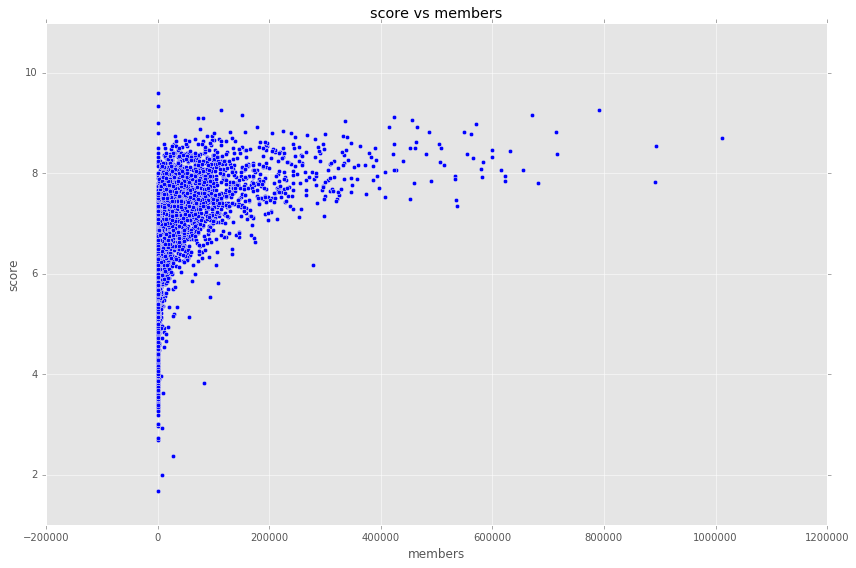

In [9]:
matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(MAL_df['members'], MAL_df['score'])
plt.xlabel("members")
plt.ylabel("score")
plt.title('score vs members')
plt.show()

Our plot here shows a few data points which hit score exactly 0 or 10. This poses the problem that titles with lower number of user scores can be heavily skewed. We address this in later analysis by using a new “bayes_score” field which normalizes the score to [0.0, 1.0] and adds an additional score of 0 and 1 to balance out the low number of scores.

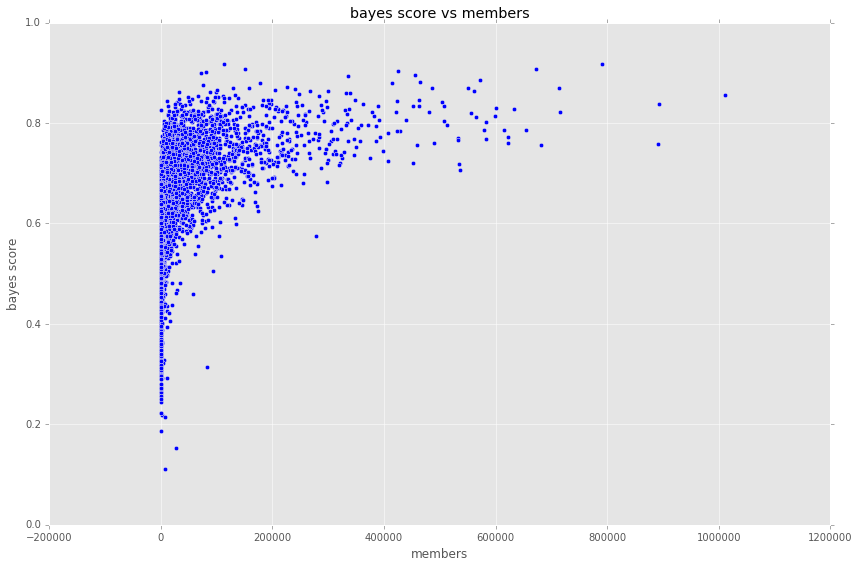

In [10]:
matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(MAL_df['members'], MAL_df['bayes_score'])
plt.xlabel("members")
plt.ylabel("bayes score")
plt.title('bayes score vs members')
plt.show()

Curiously, there seems to be a score threshold around 7.0 (.667 bayes_score): if an anime does not score at least 7.0, it is not majorly popular on MAL.

In [11]:
'''
There are a few interesting outlier which have high member count despite low scores.
These are School Days and Pupa, which are notoriously violent animes.
The incredible violence has drawn much attention despite their lack of quality. 
''';

### Genre Analysis

Before even reading the synopsis of a show, a viewer will want to know **genres** of the show. While genres are intended to be a straightforward description of a show's story, many genre carry loaded definitions due to other popular titles in that genre. For example, the tag **shounen**, which signifies shows intented for the boy's demographic, carries many expectations with it due to the popularity of shows like *DragonBall* and *One Piece*. 

With this insight, we decided to check the distributions of scores for each of the 42 relevant genres

![“Genre user plot”](images/genre_show_score_dist.png)

For the most part these scores appear to be relatively normally distributed and not terribly skewed. However, this didn't quite match our experiences with rating shows on MAL, as people normally give scores in the 8-10 range. Noting this, we then plotted the distribution of individual user scores per genre.

![“Genre user plot”](images/genre_user_score_dist.png)

The heavy-tail distribution found here matches our experiences. Something interesting to note is that the number of 10's scores is pretty large for genre's that we typically associate with being "good".

### Standard Deviations in Genres

Not quite satisfied, we also wanted to see which genre's were "controversial" to users. We measured this using the standard deviation. Below are the genres with the highest and lowest standard deviation

<table>
<tr>
    <td> <img src="images/genre_top_std.png" width="150"/> </td>
    <td> <img src="images/genre_bot_std.png" width="150"/> </td>
</tr>
</table>

We found that shows with sexual themes (i.e. the ecchi genre) tended to have a wider spread of scores compared to very niche genres (cars) and the highly popular thriller genre 

### Impact of Genre on Score

Having confirmed that our assumed associations between score and genre, we did a 1st pass linear regression on the genre tags against score and member count

<table>
<tr>
    <td> <img src="images/genre_score_reg.png" width="200"/> </td>
    <td> <img src="images/genre_member_reg.png" width="200"/> </td>
</tr>
</table>

Though our R-squared value was around 0.2, the fact that the tags mostly aligned with our notions of generally "good" genres suggested that there was a link between genre and score 

## Impact of Studios on Score

The *studios* field consists of the animation studio(s) that are primarily responsible for creating an anime. Some studios are recognizable by name in the community either because of how many titles they have released or how well received their titles have been.

Our data set features animes from 302 unique studios after collapsing branches of companies into their parent branch. Our first step was to rank the studios by the average scores of the animes they released.

In [12]:
# Some animes have more than one studio listed.
# Need to split each studio into its individual row.
split = split_field(MAL_df, 'studios')
by_studios = split.groupby('studios', as_index=False)

# Wrestling with merges in Pandas.
bigger_studios = by_studios.filter(lambda data: len(data) > 2)
bigger_studios_groups = bigger_studios.groupby('studios', as_index=False)
bigger_studios_size = bigger_studios_groups.size().to_frame('num_titles')
bigger_studios_scores_members = bigger_studios_groups[['score','members']].agg(np.mean)
bigger_studios_members_sorted = bigger_studios.sort_values('members', ascending=False).groupby('studios')
bigger_studios_max = bigger_studios_members_sorted['members'].max().to_frame('max')
bigger_studios_2nd = bigger_studios_members_sorted.nth(1)['members'].to_frame('2nd')
bigger_studios_3rd = bigger_studios_members_sorted.nth(2)['members'].to_frame('3rd')
merged = pd.merge(bigger_studios_scores_members, bigger_studios_size, how='inner', right_index=True, left_on='studios')
merged = pd.merge(merged, bigger_studios_max, how='left', left_on='studios', right_index=True)
merged = pd.merge(merged, bigger_studios_2nd, how='left', left_on='studios', right_index=True)
merged = pd.merge(merged, bigger_studios_3rd, how='left', left_on='studios', right_index=True)


# Display the top 20 scoring studios.
merged = merged.sort_values(['score', 'members'], ascending=False)
merged = merged.reset_index(drop=True)
merged[['studios', 'score', 'members', 'num_titles']].head(20)

,studios,score,members,num_titles
0,Shuka,8.050000,114522.666667,3
1,Tokyo Movie Shinsha,7.914000,12744.400000,5
2,Studio Rikka,7.762857,51490.571429,7
3,Pastel,7.743333,24877.333333,3
4,White Fox,7.660000,144073.421053,19
5,David Production,7.611538,81741.461538,13
6,Khara,7.574000,105641.400000,5
7,Square Enix,7.536667,89749.666667,3
8,Wit Studio,7.508824,114854.764706,17
9,Bones,7.434353,96479.658824,85


These results were not within our personal experience. This is because studios often produce small animations to advertise their mainline series, and these short episodes are separate entries on MAL. We decided to filter these short entries out because they "insignificant" compared to their main counterparts. We thus removed all entries whose total length was less than 30 minutes.

In [13]:
'''
Specifically, many of these are Original Video Animations (OVAs)
which are special, unaired single episodes of an anime shipped
with the anime’s DVD release.  These typically score worse than
their parent title on MAL since they generally do not advance
the parent story’s plot.
''';

In [14]:
# Get only entries that have total length greater than 30 minutes
sig_length = MAL_df[MAL_df['length'] > 30]
print "Total entries:", len(MAL_df)
print "Significant:", len(sig_length)

Total entries: 7053
Significant: 4733


In [15]:
# Split each studio into its own row
split = split_field(sig_length, 'studios')
by_studios = split.groupby('studios', as_index=False)

# Wrestle with merges and groups in Pandas
bigger_studios = by_studios.filter(lambda data: len(data) > 2)
bigger_studios_groups = bigger_studios.groupby('studios', as_index=False)
bigger_studios_size = bigger_studios_groups.size().to_frame('num_titles')
bigger_studios_scores_members = bigger_studios_groups[['score','members']].agg(np.mean)
bigger_studios_members_sorted = bigger_studios.sort_values('members', ascending=False).groupby('studios')
bigger_studios_max = bigger_studios_members_sorted['members'].max().to_frame('max')
bigger_studios_2nd = bigger_studios_members_sorted.nth(1)['members'].to_frame('2nd')
bigger_studios_3rd = bigger_studios_members_sorted.nth(2)['members'].to_frame('3rd')
merged = pd.merge(bigger_studios_scores_members, bigger_studios_size, how='inner', right_index=True, left_on='studios')
merged = pd.merge(merged, bigger_studios_max, how='left', left_on='studios', right_index=True)
merged = pd.merge(merged, bigger_studios_2nd, how='left', left_on='studios', right_index=True)
merged = pd.merge(merged, bigger_studios_3rd, how='left', left_on='studios', right_index=True)

# Display top 20 studios
merged = merged.sort_values(['score', 'members'], ascending=False)
merged = merged.reset_index(drop=True)
merged[['studios', 'score', 'members', 'num_titles']].head(20)

,studios,score,members,num_titles
0,Studio Rikka,8.250000,84874.000000,3
1,Khara,8.002500,131998.000000,4
2,Studio Ghibli,7.930000,111217.076923,13
3,Tokyo Movie Shinsha,7.914000,12744.400000,5
4,White Fox,7.813846,190162.615385,13
5,Kyoto Animation,7.770714,162370.190476,42
6,Pastel,7.743333,24877.333333,3
7,Wit Studio,7.722308,144260.538462,13
8,MAPPA,7.691250,120346.625000,8
9,David Production,7.614545,90900.818182,11


This was more in line with our expectations. Particularly interesting are the studios which have high average score despite producing more than 5 titles, such as *Studio Ghibli* (average 7.93 over 13 titles), *White Fox* (average 7.816 over 13 titles), and *Kyoto Animation* (average 7.774 over 42 titles). This indicates consistent quality from these studios, and suggests that the scores of their productions can be inferred just based on the prestige of the studio.

In [16]:
'''
Curiously, this is not exactly the list of names that fans
in the anime community will immediately recognize. A better
representation of renown is captured by the membership.
Specifically, of the studio’s produced titles, the title with
the second largest membership is a good representation of renown.
Intuitively, most fans will only start recognizing a studio’s name
after it has produced at least two well known titles. When sorting
the studios in fashion, the top 20 list quickly becomes saturated
with commonly recognized studios.
'''

# Sort by studio's anime with the 2nd largest membership
merged = merged.sort_values(['2nd'], ascending=False)
merged = merged.reset_index(drop=True)
merged[['studios', 'score', 'members', 'num_titles']].head(20)

,studios,score,members,num_titles
0,Studio Pierrot,7.277935,64118.119565,92
1,Madhouse,7.413892,77046.372973,185
2,Bones,7.562714,113925.557143,70
3,A-1 Pictures,7.546279,120609.674419,86
4,Sunrise,7.310166,41014.016575,181
5,P.A. Works,7.535556,157392.388889,18
6,Production I.G,7.489809,62826.681529,157
7,White Fox,7.813846,190162.615385,13
8,Shaft,7.547500,75083.852941,68
9,Kyoto Animation,7.770714,162370.190476,42


### Impact of Source Material on Score

Some animes are created directly for television. Many others are based on some source material, such as an existing manga or novel.

In [17]:
def make_source_features(df, source_names):
    new_df = df[['id', 'source']].copy()
    for source in source_names:
        new_df[source] = new_df['source'].apply(lambda s: s == source).astype(float)
    return new_df[source_names]

# Generate a DataFrame with boolean indicators of Source attached.
with_sources = pd.merge(MAL_df, make_source_features(MAL_df, all_sources), how='inner', left_index=True, right_index=True)

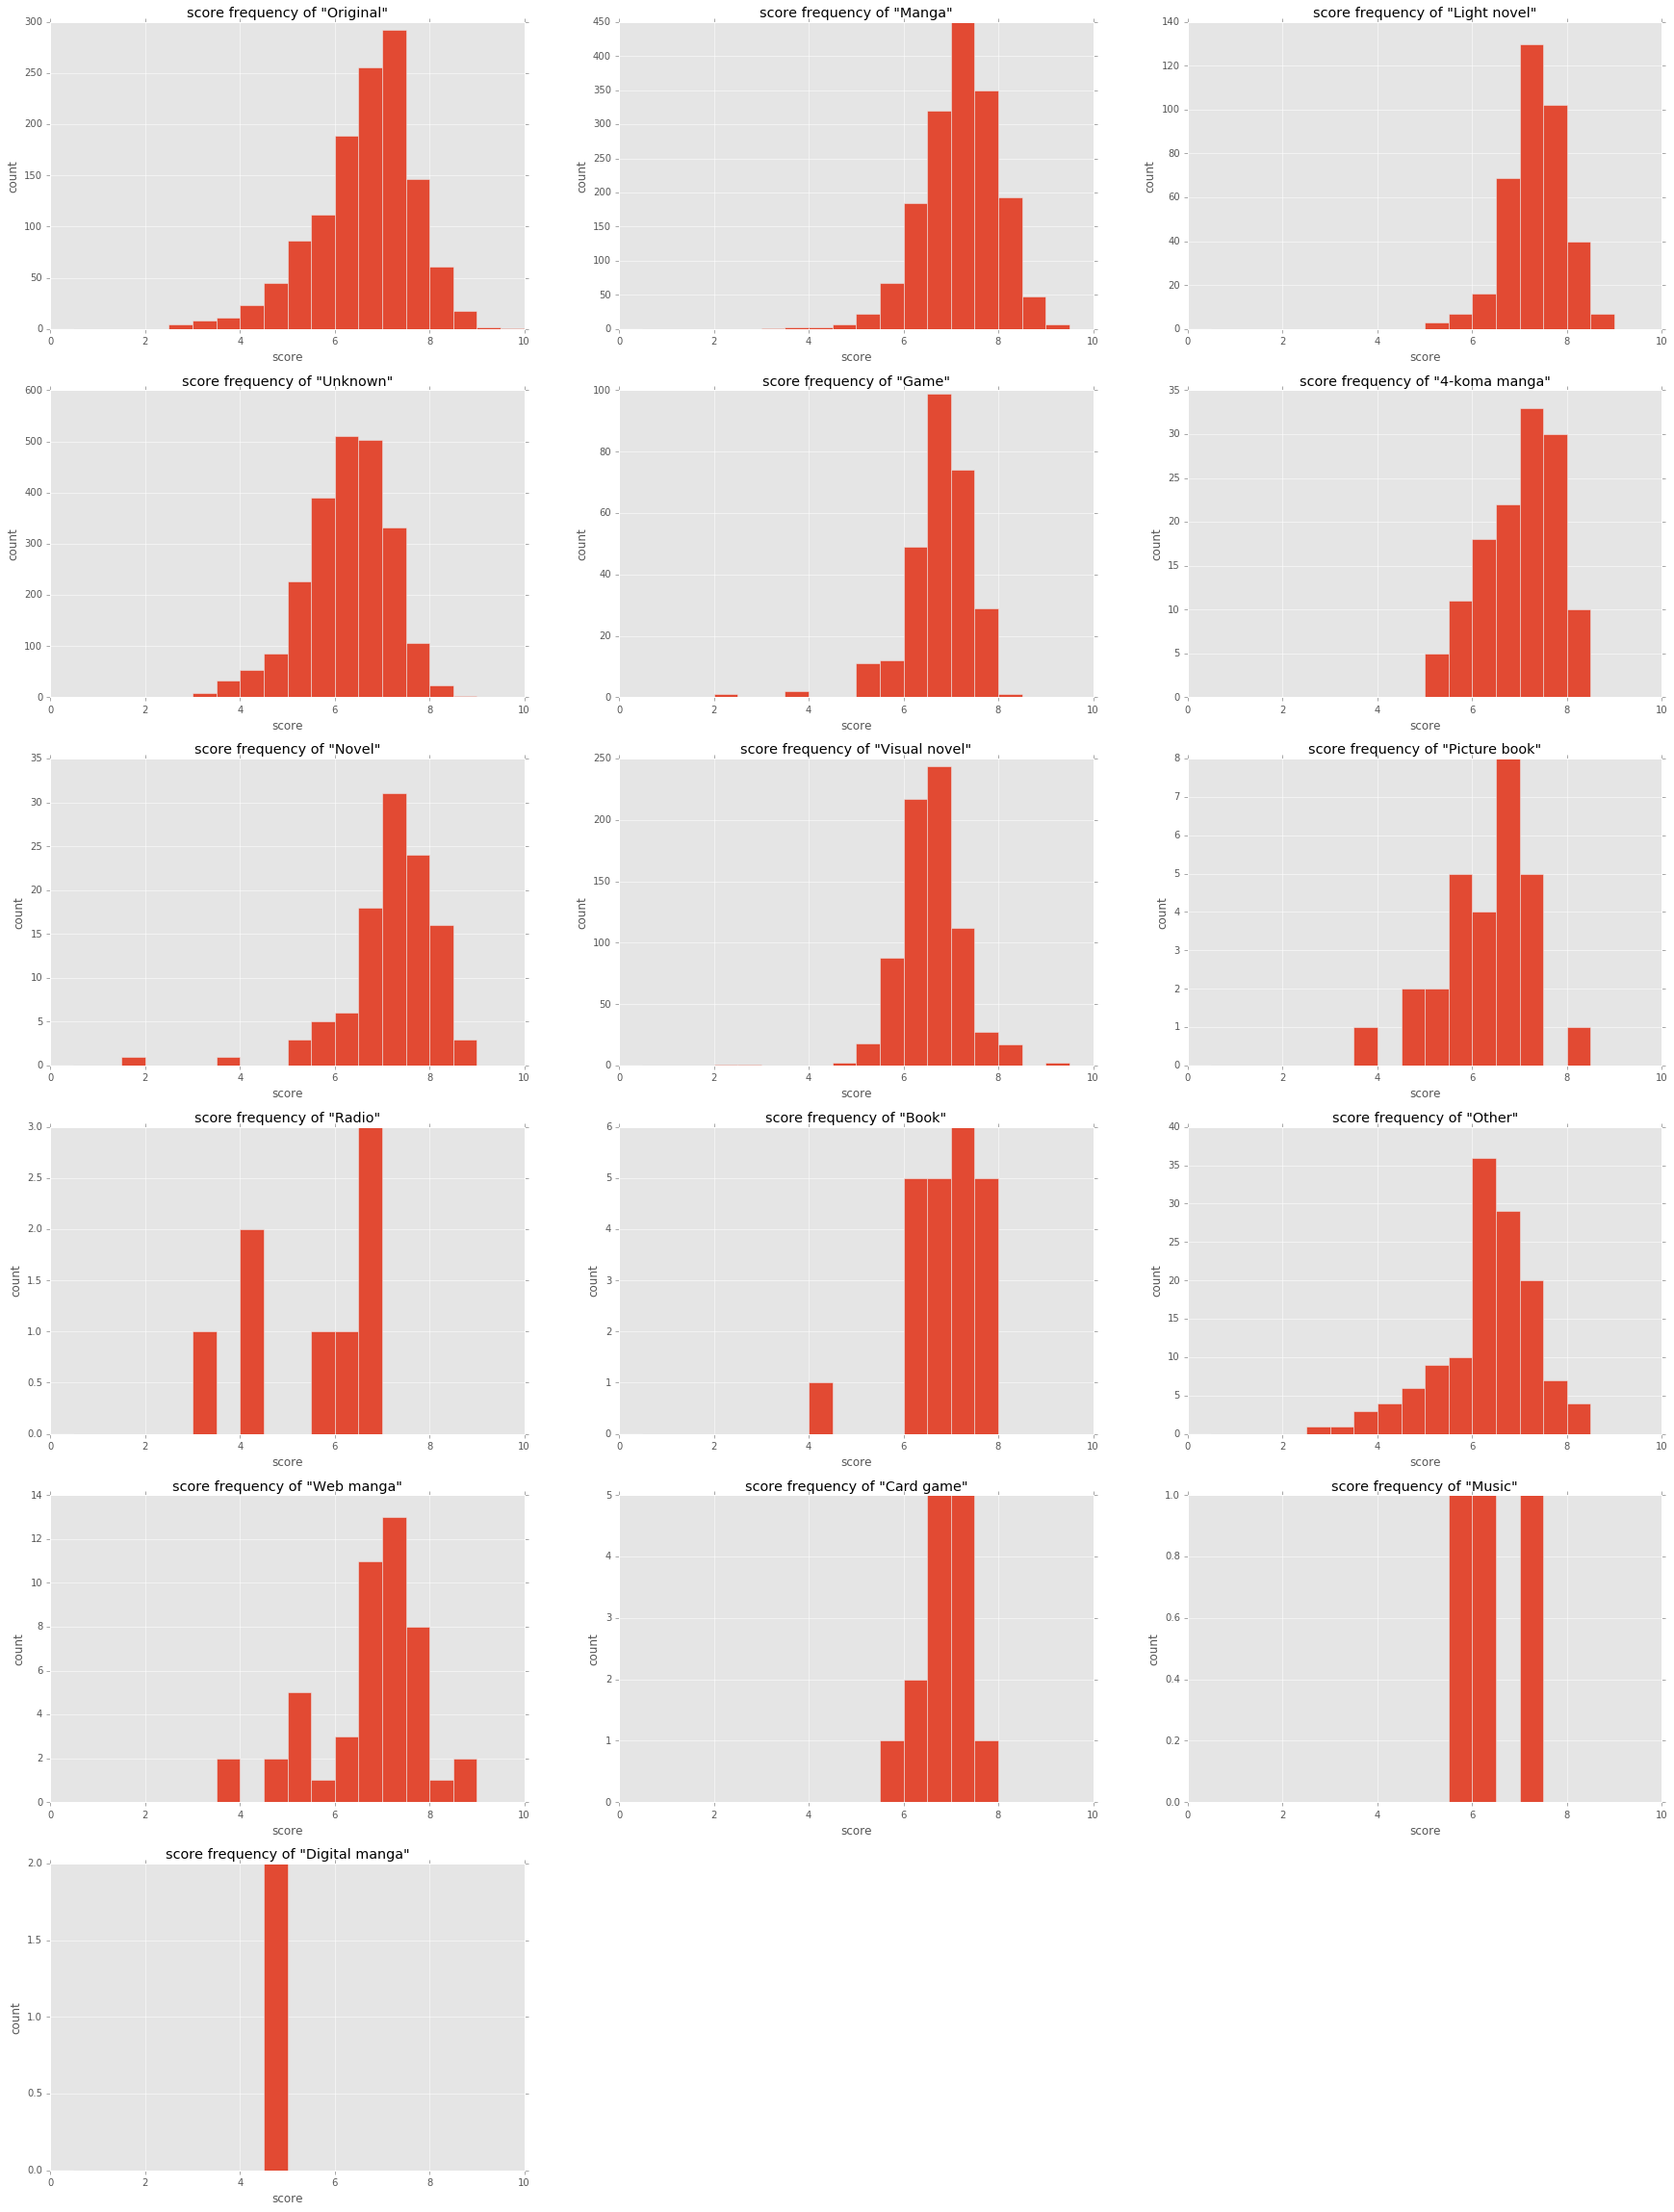

In [18]:
# Plot the score frequencies by Source Material.
matplotlib.rcParams['figure.figsize'] = (30.0, 40.0)
i = 1
for source in all_sources:
    plt.subplot(6, 3, i)
    plt.hist(with_sources[with_sources[source] == 1.0]['score'], bins=20, range=[0.0,10.0])
    plt.xlabel('score')
    plt.ylabel('count')
    plt.title('score frequency of "%s"' % source)
    i += 1

Our histogram tells us that anime original shows tend to hover around 7.0, shows based on *manga* (Japanese comics) or *light novels* (chapter books) hover higher than 7.0, and shows based on *visual novels* (interactive storytelling video games) generally sit below 7.0. This variation is significant considering that scores from 6.7 to 8.0 account for about 45% of all titles. Thus, source material is likely a factor in predicting MAL score.

In [19]:
'''
Contextually, we interpret the correlation as follows. Light novels
adaptations are highly rated because each novel in the original series
tells a complete, self-sustaining story. This translates well into
the short timeframe of 13-episode anime adaptation, as these adaptations
can usually end with all plot points addressed and without cliffhangers,
which leaves viewers satisfied with the anime. Meanwhile, manga
adaptations often occur because the source manga is already popular.
Thus the anime is also likely to be well received. In contrast,
visual novels adaptation tend to suffer because they remove the interactive
aspect of the original storytelling game. Moreover, visual novels title
typically are not as popular as mangas. Companies only produce these
adaptations because the fanbase, although small, is usually dedicated
and willing to invest in subsequent merchandise.
''';

### Synopsis Text Analysis 

*Code for this section was written in R and can be found in the Git Hub Repo*

The synopsis of a given work provides a brief explanation of setting, plot, and character details that a viewer should expect in the anime.  The free text nature of the synopsis could lead to a powerful tool for classifying different works into clusters based on the vocabulary used. Below is a word cloud across all anime synopses.

!["Main Word Cloud”](Rcode/wordclouds/all_genre.png)

We built a large document term matrix of all the synopses, and separated them by genre. We then created a frequency table of most common words.

!["Doc Term Mat"](images/documentTermMat2.png)

!["Word Frequency"](images/wordFreq.png)

In [20]:
"""
Among the most frequently used words across all the genres included:  
one, world, will, new ,school, life, however, girl, friends, two, day, and now. This alludes to larger tropes
and trends commonly found in anime, for example where the setting is a “school” and the story’s twist is
predicated with the word “however” 
""";

Separating by genre, we found that some genres had specific defining words. However, this was not enough to distinguish the genres as vocabulary tended to be similar across all works. Below is three different genre word clouds where the top 150 words are illustrated proportional to its frequency in the corpus. 

#### Action 

!["Action Word Cloud"](Rcode/wordclouds/MAL_action .png)

#### Shounen 

!["Shounen Word Cloud"](Rcode/wordclouds/MAL_shounen .png)

#### Slice Of Life 

!["Slice of Life Word Cloud"](Rcode/wordclouds/MAL_sliceoflife .png)

More word clouds for each genre can be found here.  
https://github.com/FourSwordKirby/MALDataScience/tree/master/Rcode/wordclouds

### Collecting Sequels and Related Entries into Their Parent Title

We found that many shows had sequels and related works listed on their webpage. In addition, we noticed that multiple works from the same overall series ended up near the top of our various metrics. With this in mind, we decided to see what would happen if we were to collect related entries into one overall series. 

In [21]:
"""
we took all of the works we collected and sorted them by number of members. 
This would make it so that series were denoted by their most popular work.
We then iterated through this list. For each work, we recursively found the 
id’s of its the related works to form a series that encapsulated all of those works. 
We put these series into a into a new dataframe. A show was deemed to be related if 
it’s parent has a has a link pointing to it and it has a link pointing to its parent. 
We made sure to never include the id of a show that already belonged to another series.
"""



MAL_df['norm_score'] = (MAL_df['score'] - 1.0) / 9.0
MAL_df['bayes_score'] = (MAL_df['norm_score']*MAL_df['score_users'] + 1.0) / (MAL_df['score_users'] + 2.0)
sig_length = MAL_df[(MAL_df['length'] > 30) | (MAL_df['length'] == 0)]
stat_df = sig_length.sort_values('members', ascending =False)
stat_df = stat_df.reset_index()

empty_df = stat_df[stat_df['id'] == 11111111111]
covered_ids = set([])

def getRelated(entry, covered_ids, df):
    id = entry["id"]
    related_entries = []
    
    if(id not in covered_ids):
        related_entries.append(id)
        for idx in eval(df[df['id']==id].iloc[0]['related_ids']):
            if (len(df[df['id']==idx]) > 0 and id in eval(df[df['id']==idx].iloc[0]['related_ids'])):
                covered_ids.add(id)
                new_related_entries, covered_ids = getRelated(df[df['id']==idx].iloc[0], covered_ids, df)
                related_entries.extend(new_related_entries)
    return related_entries, covered_ids
        
for idx, entry in stat_df.iterrows():
    related_entries, covered_ids = getRelated(entry, covered_ids, stat_df)
    if(len(related_entries) != 0):
        new_entry = entry
        new_entry['related_ids'] = related_entries
        empty_df = empty_df.append(entry)
        
combine_df = pd.DataFrame(empty_df,columns=['title', 'related_ids'])
combine_df["count"] = combine_df["related_ids"].apply(lambda x: len(x))

combine_df.sort_values('count', ascending =False).head(5)

,title,related_ids,count
156,Pokemon,"[527, 528, 1709, 1117, 1118, 1119, 1120, 10917...",39
1679,Futari wa Precure,"[603, 1534, 1929, 1932, 5684, 3692, 7645, 9893...",30
3821,Sore Ike! Anpanman,"[1960, 9007, 9451, 10684, 10685, 11791, 14381,...",29
30,One Piece,"[21, 459, 460, 461, 462, 463, 464, 465, 1094, ...",27
421,Detective Conan,"[235, 780, 781, 1363, 1364, 1365, 1366, 1367, ...",26


In collapsing the data, the number of entries dropped from __7053__ to __3915__
<table>
<tr>
    <td> <img src="images/series_count_30.png" width="300"/> </td>
    <td> <img src="images/series_score_30.png" width="300"/> </td>
</tr>
</table>

After removing all [insignificant works](#Impact-of-Studios-on-Score), the number of entries dropped from __4853__ to __3121__

<table>
<tr>
    <td> <img src="images/series_filter_count_30.png" width="300/"> </td>
    <td> <img src="images/series_filter_score_30.png" width="300"/> </td>
</tr>
</table>

This reduction in entries is not too surprising, as it suggests that 1 in 3 works get a second season, movie, or a significant set of DVD extras. 

## Learning MAL Scores

### Features
Our main motivation was to determine if we can predict an anime’s score based on its metadata.

Based on our data exploration, we determined that a title’s total length, genres, studios, and source material are all well associated with its MAL score. Comparatively, our synopsis text analysis demonstrated the synopsis was indicative of the genre, but not necessarily of the quality of the title. We deemed this a reasonable conclusion when we manually read the synopses, as many high scoring titles had synopses similar to those of low scoring titles.

Our learning features thus included 363 features consisting of:

* An indicator variable {0, 1} for each studios.
* An indicator variable {0, 1} for each genres.
* An indicator variable {0, 1} for each source types.
* `norm_length` = title’s total length normalized to mean 0, standard deviation 1.

In [24]:
def make_studio_features(df, studio_names):
    new_df = df[['id', 'studios']].copy()
    for studio in studio_names:
        new_df[studio] = new_df['studios'].apply(lambda l: studio in l).astype(float)
    return new_df[studio_names]

def make_source_features(df, source_names):
    new_df = df[['id', 'source']].copy()
    for source in source_names:
        new_df[source] = new_df['source'].apply(lambda s: s == source).astype(float)
    return new_df[source_names]

def make_features(df):
    p1 = make_studio_features(df, all_studios)
    p2 = df[all_genre + ['norm_length']]
    p3 = make_source_features(df, all_sources)
    join = pd.concat([p1, p2, p3], axis=1, join='inner')
    return join

make_features(MAL_df.head(5)).shape

(5, 363)

### Regression


We initially began with fitting a Linear Regression to these features to predict the MAL score. Our preliminary results were not promising, as the fits produced coefficients of correlation of low or absurd values. This was likely because the abundance of categorical variables, which were represented by indicator variables of 0 or 1, made accurate fitting impossible. However, the learned parameters of these models showed that the high scoring genres, studios, and source materials that we discovered during data exploration did tend to have larger parameters values.

### Classifying “Above Average”


We then simplified our question. Rather than predicting MAL scores exactly, we wanted to predict whether an anime was “above average” or “below average.” Anime enthusiast can intuitively make this prediction based on an anime’s metadata and description, as they can typically identify “cookie-cutter” shows which fall into the “average” or “below average” spectrum. This motivated our belief that learning algorithms could do the same.


Our data was split into a training, validation, and test set based on the starting air date: before 2012 for training, 2012-2014 for validation, and 2015 for test.

In [25]:
def split_data_by_date(df):
    df = df.sort_values('aired_start')
    t_date = pd.to_datetime('2012-01-01')
    v_date = pd.to_datetime('2015-01-01')
    train = df[df['aired_start'] < t_date]
    val   = df[(df['aired_start'] >= t_date) & (df['aired_start'] < v_date)]
    test  = df[df['aired_start'] >= v_date]
    return train, val, test

data = MAL_df

train_df, val_df, test_df = split_data_by_date(data)
print "available", data.shape[0]
print "train", train_df.shape[0]
print "validation", val_df.shape[0]
print "test", test_df.shape[0]

X_tr = make_features(train_df)
X_cv = make_features(val_df)   
X_test = make_features(test_df)

print "X_tr", X_tr.shape

available 7053
train 4689
validation 1755
test 609
X_tr (4689, 363)


The scores we used for this section are the `bayes_score` field, which is the MAL score normalized to [0.0,1.0] with an extra 0 and 1 rating. We interpreted “above average” in two ways: first, above median scores across all of the entries MAL, and second, above a MAL score of 7.2 for practical purposes.

### Above Median
For this situation, we labeled the entries according to whether its score was above or below the median MAL score (6.74 unnormalized, 0.637 normalized).

In [26]:
median_bayes_score = np.median(MAL_df['bayes_score'])
print "Median bayes_score:", median_bayes_score
print "Median Score", median_bayes_score * 9 + 1

def make_labels(df):
    return df['bayes_score'] > median_bayes_score

y_tr = make_labels(train_df)
y_cv = make_labels(val_df)
y_test = make_labels(test_df)

Median bayes_score: 0.637773539374
Median Score 6.73996185437


Using `sklearn`’s `GradientBoostingClassifier`, we scored 73.5% accuracy on the validation set, which we consider a large success over a baseline of randomly guessing.

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_tr, y_tr)

score = clf.score(X_cv, y_cv)
print "score", score

score 0.735042735043


We also tried Logistic Regression with hyperparameter `C = 1.8`.

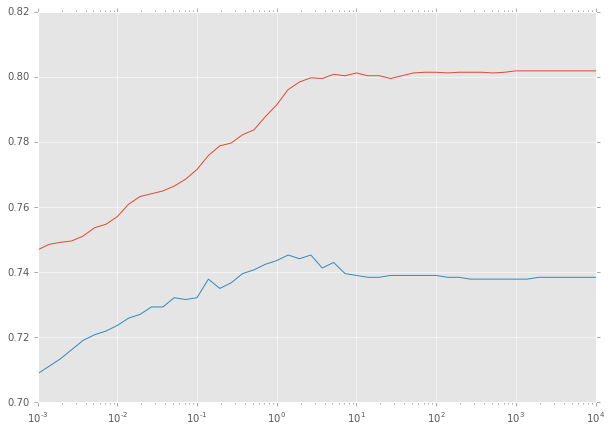

In [28]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

def get_err_reg(clf, X, y, X_cv, y_cv, C):
    clf.C = C
    clf.fit(X, y)
    return np.array([clf.score(X, y), clf.score(X_cv, y_cv)])

C = np.logspace(-3, 4, 50)
errors = np.array([get_err_reg(clf, X_tr, y_tr, X_cv, y_cv, c) for c in C])

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
plt.semilogx(C, errors[:,0], C, errors[:,1]);

In [29]:
clf = LogisticRegression(C=1.8) # Use this when considering all data, not just extremities
clf.fit(X_tr, y_tr)
print clf.score(X_tr, y_tr)
print clf.score(X_cv, y_cv)
print clf.score(X_test, y_test)

0.798037961186
0.744729344729
0.75697865353


Our classifier scored 75.7% accuracy on the 2015 test set, which broke into 78.0% accuracy on predicting above median anime, and 73.4% accuracy on predicting below median anime.

In [30]:
# Accuracy on positives
pos_idx = y_test > 0
print "Positive accuracy", clf.score(X_test[pos_idx], y_test[pos_idx])

neg_idx = y_test < 1
print "Negative accuracy", clf.score(X_test[neg_idx], y_test[neg_idx])

Positive accuracy 0.779605263158
Negative accuracy 0.734426229508


### Above Score 7.2
Practically, predicting above median is not worthwhile since the majority of the anime community has never heard of shows with scores below the median of 6.74 (evidenced by [large membership in animes which score above 7.0](#Score-and-Members)). In practice, it is more useful to know if an anime scores above average of commonly recognized shows. Our personal experiences argued that a MAL score of 7.2 more accurately represents a “practical average.” This translates to the 70th percentile, which is reasonable when assuming that most recognized titles score above the median.

In [31]:
# The following code block prints the percentile of works per category
intuitive_thresholds = [
    ('barely_watchable', 6.7),
    ('average', 7.2),
    ('above_average', 7.6),
    ('recommendable', 8.0),
    ('amazing', 8.5),
    ('gods', 9.0)
]

def to_bayes_score(score):
    return ((score - 1.0) / 9.0)

def percentages(df):
    print "Using regular score"
    for label, val in intuitive_thresholds:
        print "{} ({}): {}".format(
            label,
            val,
            1. - float(sum(df['score'] > val)) / df.shape[0])
        
    print ""
    print "Using bayes scores"
    for label, val in intuitive_thresholds:
        thresh = ((val - 1.0) / 9.0)
        print "{} ({}): {}".format(
            label,
            thresh,
            1. - float(sum( df['bayes_score'] > thresh )) / df.shape[0])
        
def percentage_bayes_score(df, score):
    return float(sum( df['bayes_score'] > score )) / df.shape[0]

print "==== Percentiles of Titles ===="
percentages(MAL_df)

==== Percentiles of Titles ====
Using regular score
barely_watchable (6.7): 0.472706649653
average (7.2): 0.695874096129
above_average (7.6): 0.852545016305
recommendable (8.0): 0.936906281015
amazing (8.5): 0.987948390756
gods (9.0): 0.99844037998

Using bayes scores
barely_watchable (0.633333333333): 0.480788317028
average (0.688888888889): 0.701120090742
above_average (0.733333333333): 0.85523890543
recommendable (0.777777777778): 0.938182333759
amazing (0.833333333333): 0.988515525308
gods (0.888888888889): 0.998723947256


In [32]:
def make_labels(df):
    return df['bayes_score'] > to_bayes_score(7.2) # ~70 percentile

y_tr = make_labels(train_df)
y_cv = make_labels(val_df)
y_test = make_labels(test_df)

Running a `GradientBoostingClassifier`, we scored 78.6% on the validation set.

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_tr, y_tr)

score = clf.score(X_cv, y_cv)
print "score", score

score 0.786324786325


Again, we tried Logistic Regression with hyperparameter `C = 1.0`.

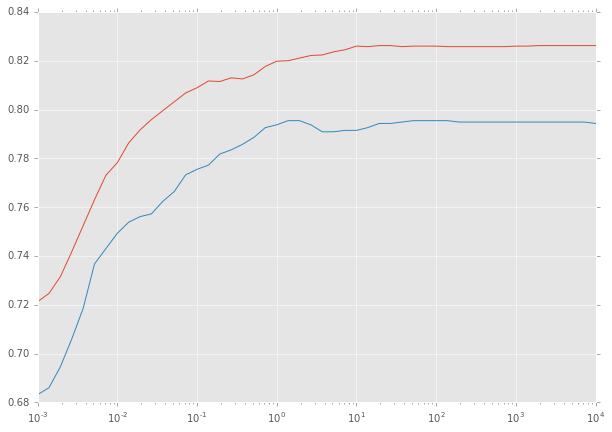

In [34]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

def get_err_reg(clf, X, y, X_cv, y_cv, C):
    clf.C = C
    clf.fit(X, y)
    return np.array([clf.score(X, y), clf.score(X_cv, y_cv)])

C = np.logspace(-3, 4, 50)
errors = np.array([get_err_reg(clf, X_tr, y_tr, X_cv, y_cv, c) for c in C])

matplotlib.rcParams['figure.figsize'] = (10.0, 7.0)
plt.semilogx(C, errors[:,0], C, errors[:,1]);

In [35]:
clf = LogisticRegression(C=1.) # Use this when considering all data for above/below 70 percentile
clf.fit(X_tr, y_tr)
print clf.score(X_tr, y_tr)
print clf.score(X_cv, y_cv)
print clf.score(X_test, y_test)

0.819791000213
0.793732193732
0.79802955665


We scored 79.8% on the test set, which breaks down into 59.8% accuracy on above practical average animes, and 88.5% accuracy on below practical average animes.

In [36]:
# Accuracy on positives
pos_idx = y_test > 0
print "Positive accuracy", clf.score(X_test[pos_idx], y_test[pos_idx])

neg_idx = y_test < 1
print "Negative accuracy", clf.score(X_test[neg_idx], y_test[neg_idx])

Positive accuracy 0.597826086957
Negative accuracy 0.884705882353


This is ~10 percentage points better accuracy than always predicting below average, and significantly better than random guessing.


When examining the Logistic Regression coefficients, we confirmed our original expectation that high scoring studios, genres, and source material would have a large influence on prediction.

In [37]:
feature_names = np.array(X_tr.columns.values)
feature_coeff = pd.DataFrame(sorted(zip(feature_names, clf.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True),
                             columns=['Feature Name', 'Coefficient'])

In [38]:
feature_coeff[feature_coeff['Feature Name'].apply(lambda s: s in all_studios)].head(15)

,Feature Name,Coefficient
0,PoRO,1.822105
1,Studio Eromatick,1.755434
2,TNK,-1.701815
3,Bridge,1.641944
4,Kyoto Animation,1.605750
5,A-1 Pictures,1.565194
6,Pink Pineapple,1.508030
7,Diomedea,1.487604
8,Actas,-1.474632
9,Manglobe,1.461976


In [39]:
feature_coeff[feature_coeff['Feature Name'].apply(lambda s: s in all_sources)].head(5)

,Feature Name,Coefficient
34,Light novel,1.047138
50,Radio,-0.912413
55,Card game,-0.807587
57,Unknown,-0.802644
74,Game,-0.716342


### Visualization of Learned Classifier

A majority of shows are properly classified, as evident by a visible division at score 7.2.

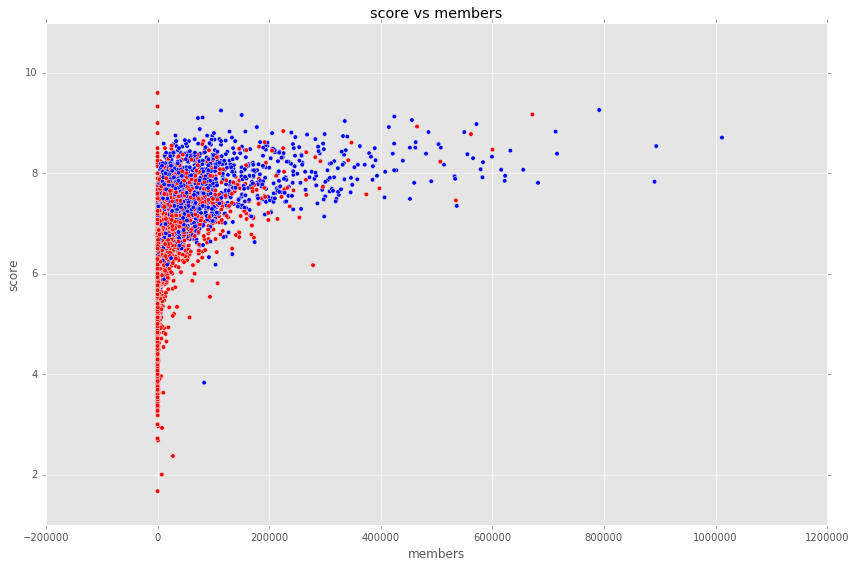

In [40]:
colors = np.array([
            [1, 0, 0],
            [0, 0, 1],
            [0, 0, 0]
        ])

classes = pd.Series(clf.predict(make_features(MAL_df)).astype(int))
colored_classes = colors[classes]

matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(MAL_df['members'], MAL_df['score'], c=colored_classes)
plt.xlabel("members")
plt.ylabel("score")
plt.title('score vs members')
plt.show()

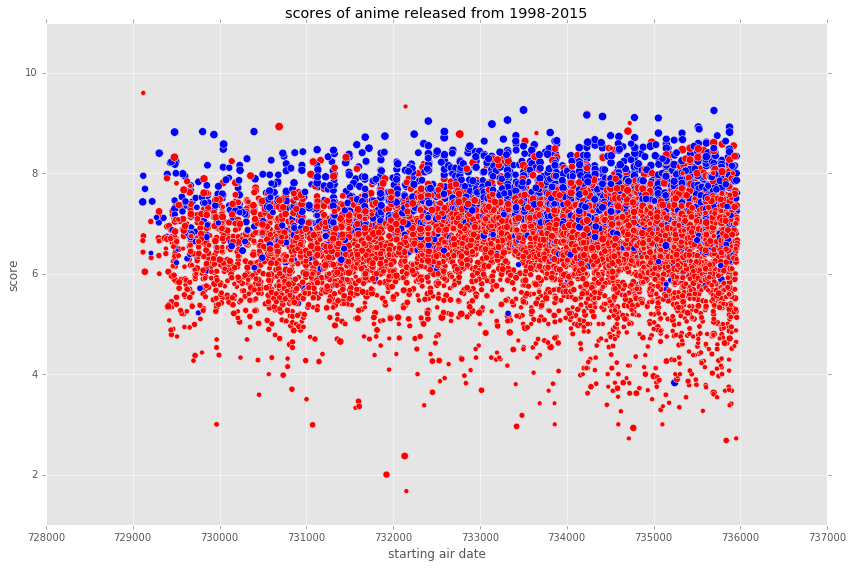

In [41]:
# This charts the scores of animes as they first aired over the years.
# The size of each dot is proportional to the number of members an anime has.
# NOTE: The time axis cannot be plotted as a date.
#       The time span stretches from 1998 -> 2016 though.
newer_shows = MAL_df[MAL_df['aired_start'] > pd.to_datetime('1997')]

colors = np.array([
            [1, 0, 0],
            [0, 0, 1],
            [.8, .8, .8]
        ])
classes = pd.Series(clf.predict(make_features(newer_shows)).astype(int))
colored_classes = colors[classes]

sizes = (np.log(newer_shows['members']) + 1) * 5

x_axis = newer_shows['aired_start'].apply(matplotlib.dates.date2num)

matplotlib.rcParams['figure.figsize'] = (14.0, 9.0)
plt.scatter(x_axis, newer_shows['score'], c=colored_classes, s=sizes)
plt.xlabel("starting air date")
plt.ylabel("score")
plt.title('scores of anime released from 1998-2015')
plt.show()

In [42]:
'''
There a few curious outliers, specifically the “above average”
show with high member count and low score that aired recently. 
This is "Pupa", as previously mentioned, an incredibly violent show.
"Pupa" was probably classified highly because of its psychological
genre and its owning studio Studio Deen, which is well known for some
other works. Ironically, the show was originally highly anticipated,
but quickly fell through the rankings as the content turned out far
below expectation. This conflicts between metadata and actual content
seems to have been reflected in our classifier.
''';

In [43]:
# Feel free to try seeing what the classifer does on certain titles.
title_to_predict = 'Amagi Brilliant Park'
clf.decision_function(make_features(MAL_df[MAL_df['title'] == title_to_predict]))

array([ 0.77766384])

## Conclusion

Our investigations into MAL data generally fell within our expectations. The association between score and member matched the notion that "popular" shows are also "good." Regarding score distrubtions, user scores tended around 7-10, but the heavy tail of low score generally brought down most score averages. Conglomerating works into their parent series reinforced our notions of what were "big" series and their quality.

Furthermore, our data demonstrated anime’s primary animation studio, its genre, and its source materials greatly associated to how well MAL judged the show. In terms of genre, “Josei” (geared towards young women), “Thriller”, “Mystery”, and “Psychological” were the best indicators of a good show. For animation studios, we found some studios which had many titles yet consistently high MAL scores, such as *Studio Ghibli*, *White Fox*, and *Kyoto Animation*. Their consistent quality served as a useful heuristic of score. In terms of source material, light novels and mangas were more likely associated with high scores than anime original shows or visual novel adaptations. In practice, we find that these three features are often used by fans to sell their favorite shows to their peers without spoiling the show’s contents.

In contrast, we found that synopses were not useful in differentiating shows, as the vocabulary was only indicitive of genre and proved to be redundant. The synopses did provide valuable insight into overarching trends and tropes common in anime, such as a focus on “one” male character in a "school" setting with a "however"-twist that drives narrative progression. 

Finally, our learning investigation showed that we can predict above or below average animes with satisfactory accuracy. We could predict above MAL median score animes with 75.7% accuracy, and above “practical average” scores with 79.8% accuracy. Both of which are a significant improvement over baselines of random guessing. Visualization illustrated that our classifications do a fair job at dividing titles at the “practical average” threshold, barring some shows whose content quality vastly differs than expected. 

## Future Work
   
The MAL website also features user recommendations and many sub-community forums. By leveraging these data sources, it might be possible to identify networks between different titles, and identify animes that are story "derivatives" of more "original" titles.

In addition, MyAnimeList houses information about the characters that appear in each show, and users can add them to their list of favorites. By leveraging this data, it could be possible to determine "popular" character traits.

In [44]:
'''
Fun Extra:
When plotting all of the shows by their score and member count,
we actually knew many of the titles that were outliers.
''';

![outliers](images/outliers.png)